In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline  

# 1. Preprocess images
    目的是将原始图片处理成模型可以进行训练的标准图片

## 1.1 RGB图像转化为灰度图像，去除彩色的影响

In [106]:
# load image
img = cv2.imread('../data/raw/6BYF.jpg',cv2.IMREAD_UNCHANGED)

In [107]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

Text(0.5, 1.0, 'Gray image')

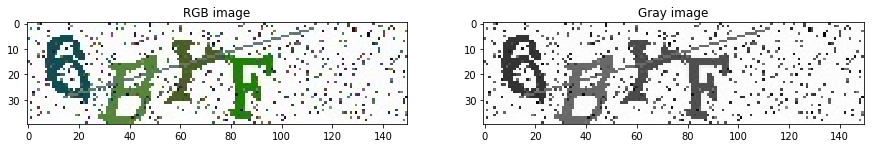

In [108]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(rgb_img)
ax2.imshow(gray_img,cmap=plt.get_cmap('gray'))
ax1.set_title('RGB image')
ax2.set_title('Gray image')


## 1.2  进一步去除灰度深浅的影响

In [109]:
gray_threshold = 160
binary_img = np.where(gray_img < gray_threshold,0,255).astype('uint8')

# 还可以使用cv内置的函数来实现
ret, binary_img2 = cv2.threshold(img,gray_threshold,255,cv2.THRESH_BINARY)

Text(0.5, 1.0, 'Binary2 image')

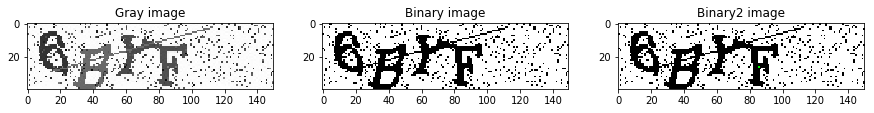

In [110]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,15))
ax1.imshow(gray_img,cmap=plt.get_cmap('gray'))
ax2.imshow(binary_img,cmap=plt.get_cmap('gray'))
ax3.imshow(binary_img2,cmap=plt.get_cmap('gray'))
ax1.set_title('Gray image')
ax2.set_title('Binary image')
ax3.set_title('Binary2 image')

## 1.3 去除噪点

采用8邻域像素算法：某个像素点与之相邻的8个像素点中，有一半都是背景色，那们这个像素点也应该置为背景色，我们可以使用卷积来实现这一想法

In [111]:
kernel = np.ones((4,4),np.float32)/16

blur = cv2.filter2D(binary_img,-1,kernel)
clean_img = np.where(blur < blur.mean()*0.6,0,255).astype('uint8')

Text(0.5, 1.0, 'remove noise')

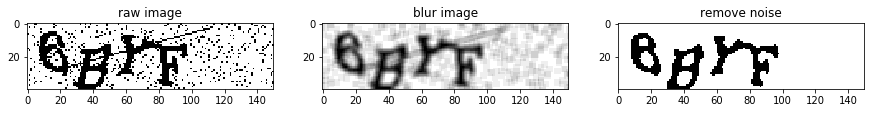

In [112]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,15))
ax1.imshow(binary_img,cmap=plt.get_cmap('gray'))
ax2.imshow(blur,cmap=plt.get_cmap('gray'))
ax3.imshow(clean_img,cmap=plt.get_cmap('gray'))
ax1.set_title('raw image')
ax2.set_title('blur image')
ax3.set_title('remove noise')


## 1.4 字符切割

将每张图片切割成四个字符，用于后续训练

In [116]:
def split_image_into_subimage(image, width_max=40, width_min=10):
    # 将每张图片切割成四个字符，用于后续训练
    # width_max: 限制最大宽度
    # width_min: 限制最小宽度
    # min_area 限制最小面积
    
    # 外围加一个padding
    image_with_bord = cv2.copyMakeBorder(image,1,1,1,1, cv2.BORDER_CONSTANT,value=[255]) 
    
    # 找轮廓算法
    img, contours, hierarchy = cv2.findContours(image_with_bord.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sub_images = []
    sub_images_x = []  
    for cnt in contours:
        # 最小的外接矩形
        x, y, w, h = cv2.boundingRect(cnt)
        if x != 0 and y != 0 and w>width_min:   #w*h >= min_area:
            # 显示图片
            if w > width_max:
                w = int(w/2)
                sub_images.append(image_with_bord[y:y+h, x:x+w])
                sub_images_x.append(x)
                
                sub_images.append(image_with_bord[y:y+h, x+w:x+2*w])
                sub_images_x.append(x)
                continue
            sub_images.append(image_with_bord[y:y+h, x:x+w])
            sub_images_x.append(x)
            
    seq_index = np.argsort(sub_images_x)
    return [sub_images[i]  for i in seq_index]

In [117]:
sub_images = split_image_into_subimage(clean_img)

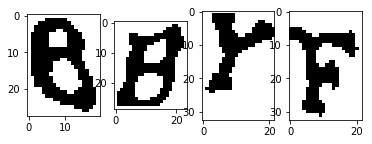

In [118]:
f2, axes = plt.subplots(1, 4)
for index,sub_img in enumerate(sub_images[:4]):
    axes[index].imshow(sub_img,cmap=plt.get_cmap('gray'))

In [119]:
def resize_with_padding(image,desired_height=40,desired_width=40):
    # The main idea is to first resize the input image so that its maximum size 
    # equals to the given size. Then we pad the resized image to make it square. 
    # A number of packages in Python can easily achieves this
    old_size = image.shape[:2]   # old_size is in (height, width) format
   
    ratio = float(max([desired_height,desired_width]))/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    # new_size should be in (width, height) format
    im = cv2.resize(image, (new_size[1], new_size[0]))
    
    delta_w = desired_width - new_size[1]
    delta_h = desired_height - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [255, 255, 255]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_im

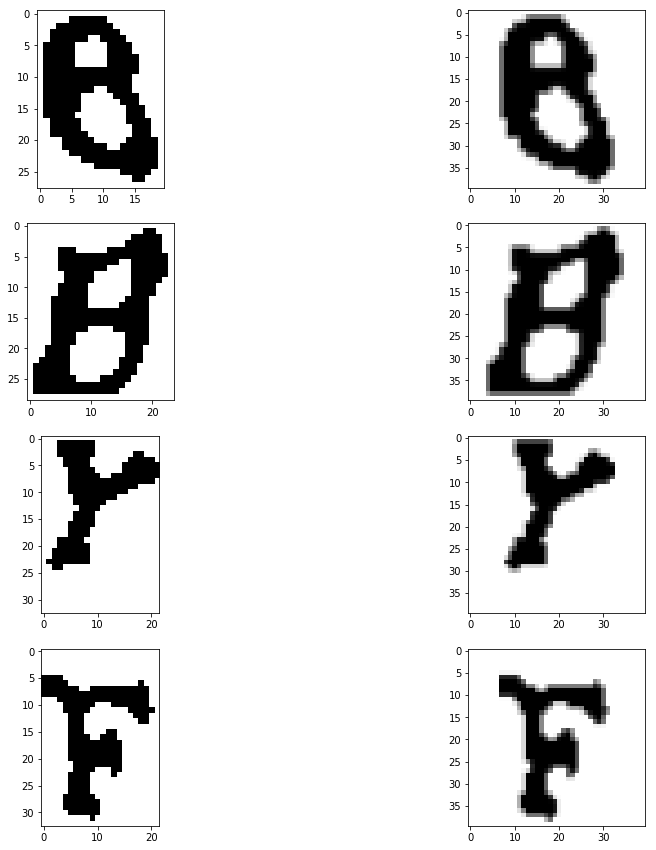

In [120]:
h_n, v_n = 2,4
f, axes = plt.subplots(v_n, h_n,figsize=(15,15))

resized_subimage = []

for i in range(v_n):
    axes[i][0].imshow(sub_images[i],cmap=plt.get_cmap('gray'))
    sub_img_resize = resize_with_padding(sub_images[i])
    resized_subimage.append(sub_img_resize.reshape(40,40,1))
    axes[i][1].imshow(sub_img_resize,cmap=plt.get_cmap('gray'))


# 2.  Training

# 3. predicting

In [68]:
from keras.models import model_from_json


Using TensorFlow backend.


In [102]:
with open('../models/model_num.json', 'r') as json_file:
    model = model_from_json(json_file.read())
    model.load_weights("../models/model_num-1583664747.61.h5")

In [121]:
X = np.stack(resized_subimage, axis=0)

In [122]:
model.predict_classes(x=X)

array([ 6, 11, 31, 15])